In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import math
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV, cross_val_predict, TimeSeriesSplit, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, recall_score, make_scorer, average_precision_score
from keras.optimizers import Adam, RMSprop, SGD 

# 4.- Entrenamiento de Algoritmos

# Índice

- [4.1.- Carga de particiones)](#41)
- [4.2.- Funciones para particionado interno](#42)
- [4.3.- Funciones auxiliares](#43)
- [4.4.- Funciones para entrenamiento de modelos y definición de métrica](#44)
- [4.5.- Entrenamiento de modelos](#45)
>- [4.5.1.- Entrenamiento para Estrategia de Eliminación de Valores Ausentes](#451)
>- [4.5.2.- Entrenamiento para Estrategia de Imputación de Valor Medio para Valores Ausentes](#452)
>- [4.5.3.- Entrenamiento para Estrategia de Imputación mediante KNN para Valores Ausentes](#453)
- [4.6.- Obtención de mejores modelos](#46)
- [4.7.- Interpretabilidad de modelo Regresión Logística](#47)
- [4.8.- Obtención de fronteras de decisición para modelos CART](#48)
- [4.9.- Curvas ROC y Precisión-Sensibilidad para mejor modelo](#49)
- [4.10.- Almacenamiento de modelos y tablas de resultados](#410)

<a id="41"></a>
## 4.1.- Carga de particiones
Se realizará a continuación el entrenamiento de los diferentes algoritmos seleccionados como posibles candidatos para el modelo predictivo final.

Comenzaremos cargando las distintas particiones que se tienen preparadas de las fases anteriores:

In [2]:
# Modificación de parámetros de visualización para que dado que el número de columnas es grande se muestren todas a la vez
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

# Carga de datos desde ficheros Pickle

    # Ausentes eliminados
with open('../particiones/preprocesadas/X_train_std_disc_deleted.pkl', 'rb') as f:
    X_train_std_deleted = pickle.load(f)

with open('../particiones/preprocesadas/y_train_deleted.pkl', 'rb') as f:
    y_train_deleted = pickle.load(f)

with open('../particiones/preprocesadas/X_test_std_disc_deleted.pkl', 'rb') as f:
    X_test_std_deleted = pickle.load(f)

with open('../particiones/preprocesadas/y_test_deleted.pkl', 'rb') as f:
    y_test_deleted = pickle.load(f)


    # Ausentes imputación media
with open('../particiones/preprocesadas/X_train_std_disc_media.pkl', 'rb') as f:
    X_train_std_media = pickle.load(f)

with open('../particiones/preprocesadas/y_train_media.pkl', 'rb') as f:
    y_train_media = pickle.load(f)

with open('../particiones/preprocesadas/X_test_std_disc_media.pkl', 'rb') as f:
    X_test_std_media = pickle.load(f)

with open('../particiones/preprocesadas/y_test_media.pkl', 'rb') as f:
    y_test_media = pickle.load(f)


    # Ausentes imputación KNN
with open('../particiones/preprocesadas/X_train_std_disc_knn.pkl', 'rb') as f:
    X_train_std_knn = pickle.load(f)

with open('../particiones/preprocesadas/y_train_knn.pkl', 'rb') as f:
    y_train_knn = pickle.load(f)

with open('../particiones/preprocesadas/X_test_std_disc_knn.pkl', 'rb') as f:
    X_test_std_knn = pickle.load(f)

with open('../particiones/preprocesadas/y_test_knn.pkl', 'rb') as f:
    y_test_knn = pickle.load(f)


    # Columnas auxiliares de años
with open('../preprocesadores/columna_anios_deleted.pkl', 'rb') as f:
    columna_anios_deleted = pickle.load(f)

with open('../preprocesadores/columna_anios.pkl', 'rb') as f:
    columna_anios = pickle.load(f)



<a id="42"></a>
## 4.2.- Funciones para particionado interno

Tal como se indicó durante el proceso de particionado externo (Hold-out), al estar trabajando con series temporales se debe evitar la fuga de datos entre particiones, es decir, en la partición de entrenamiento no pueden existir datos correspondientes a instantes posteriores a los contenidos en la partición de validación. Como consecuencia no se usará el habitual KFold.

Cuando se trabaja con series temporales es habitual hacer uso de “TimeSeriesSplit”, que va creando particiones de tamaño progresivo usando los datos de manera secuencial, de esta forma se garantiza la no existencia de la ya citada fuga de datos. Sin embargo, dado el elevado desbalance de las clases en el conjunto de datos, la posibilidad de uso de “TimeSeriesSplit” se ve invalidada ya que nada garantiza la existencia de muestras de ambas clases en todas las particiones.

Para afrontar esta situación se ha optado por crear una función customizada para la creación de las distintas particiones, de manera que se asegure por un lado la coherencia temporal (no existencia de fuga de datos entre particiones de entrenamiento y validación), y por otro la existencia de instancias de ambas clases (0: “No Crisis” y 1: “Pre-Crisis”, siendo ésta última la clase minoritaria), imitando para ello el comportamiento de “TimeSeriesSplit”.

En ambos casos se reparten las muestras de la clase minoritaria entre las particiones, las cuales se crean de manera secuencial en lo que a datos se refiere. La partición de entrenamiento de cada fold (excepto para el primero), se obtiene uniendo las particiones de entrenamiento y validación del paso anterior y se calcula una nueva partición de validación (con este comportamiento el último fold siempre usará el volumen completo de los datos).

Se muestran a continuación las funciones tanto para crear las particiones a usar en cross-validation, como el particionado entrenamiento-validación para aquellos modelos en los que no se usará cross-validation:

In [3]:
def custom_cross_val(y_train, columna_anios, n_folds=5):
    crisis = 0
    posicion = 0
    posicion_inicial=0
    folds = []
    aux=[]

    # En base al número total de instancias positivas (`Pre-Crisis'), en el dataset calculamos cúantas podría
    # haber en cada partición
    reparto=math.floor(y_train.sum()/(n_folds+1))


    temporal = pd.DataFrame(np.concatenate((np.expand_dims(y_train, axis=1), np.expand_dims(columna_anios, axis=1)), axis=1),
                            columns=['crisis', 'year'])
    acumulados = temporal.groupby('year').sum()['crisis'].cumsum() 

    if n_folds==1:
        anio_division = int(max(acumulados[acumulados<=reparto].index))

        # Número mínimo de instancias positivas que hay en todas las particiones para definir posteriormente el 
        # número máximo de vecinos en SMOTE
        minimo = int(max(acumulados[acumulados<=reparto]))
        aux.append(list(temporal[temporal['year'] <= anio_division].index))
        aux.append(list(temporal[temporal['year'] > anio_division].index))
        folds.append((aux[0],aux[1]))
    else:
        contador = 1
        anio_division_anterior = 0
        for _ in range(2):
            if contador == 1:
                minimo = int(max(acumulados[acumulados<=reparto]))
            anio_division = int(max(acumulados[acumulados<=(reparto*contador)].index))
            aux.append(list(temporal[(temporal['year'] > anio_division_anterior) & (temporal['year'] <= anio_division)].index))
            anio_division_anterior = anio_division
            contador += 1
        folds.append((aux[0],aux[1]))
        for _ in range(n_folds-2):
            # aux[0] = aux[0] + aux[1]
            aux[0] = list(temporal[temporal['year'] <= anio_division_anterior].index)
            anio_division = int(max(acumulados[acumulados<=(reparto*contador)].index))
            aux[1] = list(temporal[(temporal['year'] > anio_division_anterior) & (temporal['year'] <= anio_division)].index)
            anio_division_anterior = anio_division
            contador += 1
            folds.append((aux[0],aux[1]))
        aux[0] = list(temporal[temporal['year'] <= anio_division].index)
        aux[1] = list(temporal[temporal['year'] > anio_division].index)
        folds.append((aux[0],aux[1]))
    return folds, minimo

In [4]:
def custom_split(X_train, y_train, columna_anios):
    crisis = 0
    posicion = 0
    posicion_inicial=0
    splits = []

    # Número mínimo de instancias positivas que hay en todas las particiones para definir posteriormente el 
    # número máximo de vecinos en SMOTE
    minimo=math.floor(y_train.sum()/2)
    temporal = pd.DataFrame(np.concatenate((np.expand_dims(y_train, axis=1), np.expand_dims(columna_anios, axis=1)), axis=1), columns=['crisis', 'year'])
    acumulados = temporal.groupby('year').sum()['crisis'].cumsum() 
    anio_division = int(max(acumulados[acumulados<=minimo].index))
    posicion = max(list(temporal[temporal['year'] <= anio_division].index)) + 1
    splits.append(X_train[0:posicion])
    splits.append(y_train[0:posicion])
    splits.append(X_train[posicion:])
    splits.append(y_train[posicion:])

    return splits

<a id="43"></a>
## 4.3.- Funciones auxiliares

In [5]:
def show_cf_matrix(cf_matrix, fichero):
    # Presentación de la matriz de confusión
    plt.figure(figsize=(3, 3))
    labels = ['No Crisis', 'Pre-Crisis']
    sns.set()
    sns.heatmap(cf_matrix,annot=True, fmt="d", cmap='Oranges', linewidths=0.1, xticklabels=labels, yticklabels=labels)
    plt.title("Matriz de Confusión")

    # Guardo para usar en la app
    if not os.path.exists('../app/graficas'):
        os.mkdir('../app/graficas')
    plt.savefig('../app/graficas/' + fichero)
    
    plt.show()

<a id="44"></a>
## 4.4.- Funciones para entrenamiento de modelos y definición de métrica

El entrenamiento se ha separado en dos partes. Por un lado se entrenarán los siguientes algoritmos clásicos de Aprendizaje Supervisado
+ Regresión Logística.
+ Support Vector Classifier (SVC).
+ Árboles de Decisión Simples (CART).
+ Random Forest Classifier.
+ Adaboost.

Para estos algoritmos se hará uso de GridSearchCV (usando la anterior función creada para la obtención de folds para cross-validation), para encontrar los hiperparámetros óptimos. Una vez encontrados se entrenará el modelo con el conjunto completo de datos de entrenamiento.

Por otro lado se entrenará una red neuronal muy simple (perceptrón multicapa), usando uso de la función creada para dividir la partición de entrenamiento en entrenamiento y validación. 

Para cada uno de los algoritmos se emplearán las siguientes técnicas de balanceo de muestras dado el elevado desbalance del presente conjunto de datos:
+ SMOTE (Syntetic Minority Oversampling Technique).
+ RandomOverSampler.
+ RandomUnderSampler.
+ Balance de pesos.

En el caso de GridSearchCV se usará como entrada un estimador compuesto por un pipeline dado que el balanceo debe realizarse sobre la partición de entrenamiento de cada fold.

En casos como el presente u otros parecidos (como pueden ser detección de fraude, anomalías, etc.), donde el volumen de muestras de la clase minoritaria es muy bajo comparado con el de muestras de la clase mayoritaria, lo que se suele buscar es una métrica que maximice el número de verdaderos positivos, pero manteniendo un equilibrio con el número de falsos positivos, los cuales estarían representando falsas alarmas que deberían ser revisadas con los posibles costes asociados que ésto podría suponer. Una métrica que nos permite evaluar dicho equilibrio es “sklearn.metrics.average_precision_score”, que calcula una aproximación del área bajo la curva precisión-sensibilidad (Area Under the Precision-Recall Curve, AUPRC en inglés), métrica que en casos de datos desbalanceados suele considerarse más estable que el área bajo la curva Característica Operativa del Receptor (Area Under the Receiver Operating Characteristic Curve, ROC-AUC). Para el uso de dicha métrica se creará un scorer customizado.

Una vez entrenados los modelos se obtendrán distintas métricas, matrices de confusión, etc., para su posterior comparación.

In [6]:
def modelos_supervisado (X_train, y_train, X_test, y_test, tabla_resultados, columna_anios, estrategia, n_folds=5):
    custom_cv, minimo = custom_cross_val(y_train, columna_anios, n_folds)
    modelos = []
    algs = {'LOGR_SMOTE': make_pipeline(SMOTE(random_state=42, k_neighbors=minimo-1), LogisticRegression(max_iter=100000)),
            'RF_SMOTE': make_pipeline(SMOTE(random_state=42, k_neighbors=minimo-1), RandomForestClassifier(random_state=42)),
            'SVM_SMOTE': make_pipeline(SMOTE(random_state=42, k_neighbors=minimo-1), SVC(probability=True, max_iter=100000)),
            'ADB_SMOTE': make_pipeline(SMOTE(random_state=42, k_neighbors=minimo-1), AdaBoostClassifier(random_state=42)),
            'CART_SMOTE': make_pipeline(SMOTE(random_state=42, k_neighbors=minimo-1), DecisionTreeClassifier(random_state=42)),
            'LOGR_UNDER': make_pipeline(RandomUnderSampler(random_state=42), LogisticRegression(max_iter=100000)),
            'RF_UNDER': make_pipeline(RandomUnderSampler(random_state=42), RandomForestClassifier(random_state=42)),
            'SVM_UNDER': make_pipeline(RandomUnderSampler(random_state=42), SVC(probability=True, max_iter=100000)),
            'ADB_UNDER': make_pipeline(RandomUnderSampler(random_state=42), AdaBoostClassifier(random_state=42)),
            'CART_UNDER': make_pipeline(RandomUnderSampler(random_state=42), DecisionTreeClassifier(random_state=42)),
            'LOGR_OVER': make_pipeline(RandomOverSampler(random_state=42), LogisticRegression(max_iter=100000)),
            'RF_OVER': make_pipeline(RandomOverSampler(random_state=42), RandomForestClassifier(random_state=42)),
            'SVM_OVER': make_pipeline(RandomOverSampler(random_state=42), SVC(probability=True, max_iter=100000)),
            'ADB_OVER': make_pipeline(RandomOverSampler(random_state=42), AdaBoostClassifier(random_state=42)),
            'CART_OVER': make_pipeline(RandomOverSampler(random_state=42), DecisionTreeClassifier(random_state=42)),
            'LOGR_BAL': make_pipeline(LogisticRegression(max_iter=100000, class_weight='balanced')),
            'RF_BAL': make_pipeline(RandomForestClassifier(random_state=42, class_weight='balanced_subsample')),
            'SVM_BAL': make_pipeline(SVC(probability=True, class_weight='balanced', max_iter=100000)),
            'CART_BAL': make_pipeline(DecisionTreeClassifier(random_state=42, class_weight='balanced'))
       }
    
        # Creamos un diccionario con los parámetros a probar para encontrar la mejor combinación para cada algoritmo
    params = {'LOGR_SMOTE': {'logisticregression__fit_intercept': (True, False), 'logisticregression__solver': ('sag', 'saga', 'lbfgs'), 'logisticregression__penalty': ('l2', None)},
              'RF_SMOTE': {'randomforestclassifier__n_estimators': (10, 50, 100), 'randomforestclassifier__criterion': ('gini', 'entropy'), 'randomforestclassifier__max_depth': (1, 2, 3, 4, 5, 6 ,7)},
              'SVM_SMOTE': {'svc__C': (0.1, 1, 10), 'svc__gamma': (0.1, 1, 10), 'svc__kernel': ('linear', 'poly', 'rbf')},
              'ADB_SMOTE': {'adaboostclassifier__n_estimators': (5, 10, 15), 'adaboostclassifier__algorithm': ('SAMME', 'SAMME.R')},
              'CART_SMOTE': {'decisiontreeclassifier__criterion': ('gini', 'entropy'), 'decisiontreeclassifier__max_depth': (1, 2, 3, 4, 5, 6 ,7)},
              'LOGR_UNDER': {'logisticregression__fit_intercept': (True, False), 'logisticregression__solver': ('sag', 'saga', 'lbfgs'), 'logisticregression__penalty': ('l2', None)},
              'RF_UNDER': {'randomforestclassifier__n_estimators': (10, 50, 100), 'randomforestclassifier__criterion': ('gini', 'entropy'), 'randomforestclassifier__max_depth': (1, 2, 3, 4, 5, 6 ,7)},
              'SVM_UNDER': {'svc__C': (0.1, 1, 10), 'svc__gamma': (0.1, 1, 10), 'svc__kernel': ('linear', 'poly', 'rbf')},
              'ADB_UNDER': {'adaboostclassifier__n_estimators': (5, 10, 15), 'adaboostclassifier__algorithm': ('SAMME', 'SAMME.R')},
              'CART_UNDER': {'decisiontreeclassifier__criterion': ('gini', 'entropy'), 'decisiontreeclassifier__max_depth': (1, 2, 3, 4, 5, 6 ,7)},
              'LOGR_OVER': {'logisticregression__fit_intercept': (True, False), 'logisticregression__solver': ('sag', 'saga', 'lbfgs'), 'logisticregression__penalty': ('l2', None)},
              'RF_OVER': {'randomforestclassifier__n_estimators': (10, 50, 100), 'randomforestclassifier__criterion': ('gini', 'entropy'), 'randomforestclassifier__max_depth': (1, 2, 3, 4, 5, 6 ,7)},
              'SVM_OVER': {'svc__C': (0.1, 1, 10), 'svc__gamma': (0.1, 1, 10), 'svc__kernel': ('linear', 'poly', 'rbf')},
              'ADB_OVER': {'adaboostclassifier__n_estimators': (5, 10, 15), 'adaboostclassifier__algorithm': ('SAMME', 'SAMME.R')},
              'CART_OVER': {'decisiontreeclassifier__criterion': ('gini', 'entropy'), 'decisiontreeclassifier__max_depth': (1, 2, 3, 4, 5, 6 ,7)},
              'LOGR_BAL': {'logisticregression__fit_intercept': (True, False), 'logisticregression__solver': ('sag', 'saga', 'lbfgs'), 'logisticregression__penalty': ('l2', None)},
              'RF_BAL': {'randomforestclassifier__n_estimators': (10, 50, 100), 'randomforestclassifier__criterion': ('gini', 'entropy'), 'randomforestclassifier__max_depth': (1, 2, 3, 4, 5, 6 ,7)},
              'SVM_BAL': {'svc__C': (0.1, 1, 10), 'svc__gamma': (0.1, 1, 10), 'svc__kernel': ('linear', 'poly', 'rbf')},
              'CART_BAL': {'decisiontreeclassifier__criterion': ('gini', 'entropy'), 'decisiontreeclassifier__max_depth': (1, 2, 3, 4, 5, 6 ,7)}
         }

        # Recorremos mediante bucle para evaluar
    model = {}
    for name, _ in algs.items():
        model_cv = GridSearchCV(algs[name], params[name], error_score='raise', cv=custom_cv, scoring=avg_pres_score_pos, return_train_score=True, verbose=0, n_jobs=-1)
        model[name] = model_cv.fit(X_train, y_train)
        mejor_iter = model[name].best_index_
        mejor_params = model[name].best_params_
        roc_auc_media = model[name].cv_results_['mean_test_score'][mejor_iter]
        roc_auc_std = model[name].cv_results_['std_test_score'][mejor_iter]
        print(f'---------------------------\nAlgoritmo {name}\n\nMejor Score: {model[name].best_score_}')
        print(f'Mejores parámetros: {mejor_params}\nAverage-Precision: {roc_auc_media:0.3f} +/- {roc_auc_std:0.3f}')

        # Entrenamos con la partición completa de entrenamiento 
        imba_pipeline = algs[name]
        imba_pipeline.set_params(**model[name].best_params_)
        model_comp = imba_pipeline.fit(X_train, y_train)
        modelos.append(model_comp)

        # Predecimos los resultados usando la partición de test
        y_pred = model_comp.predict(X_test)
        y_proba = model_comp.predict_proba(X_test)
        pre = metrics.precision_score(y_test, y_pred, average='macro')
        sen = metrics.recall_score(y_test, y_pred, average='macro')
        f1 = metrics.f1_score(y_test, y_pred, average='macro')
        acc = metrics.accuracy_score(y_test, y_pred)
        roc_auc = metrics.roc_auc_score(y_test, y_pred)
        pr_auc = metrics.average_precision_score(y_test, y_pred)

        # Almacenamos los resultados
        dict = {name : [pre, sen, f1, acc, roc_auc, pr_auc]}
        tabla_resultados = pd.concat([tabla_resultados, pd.DataFrame(dict, index=['Precisión', 'Sensibilidad', 'F1', 'Accuracy', 'ROC-AUC','Precision-Recall'])], axis=1)

        nombre_imagen = estrategia + '_' + name + '.png'
        show_cf_matrix(metrics.confusion_matrix(y_test, y_pred), nombre_imagen)
        print('\nClassification Report')
        print(metrics.classification_report(y_test, y_pred, target_names=['No Crisis', 'Pre-Crisis']))
        print(f'---------------------------\n')

    return modelos, tabla_resultados

In [7]:
def modelos_MLP(X_train, y_train, X_test, y_test, tabla_resultados, columna_anios, estrategia):
    modelos = []
    # Creamos red neuronal simple:
    model = Sequential()
    model.add(Dense(8, input_shape=(X_train.shape[1],), activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid")) 
    model.compile(loss='binary_crossentropy', optimizer=Adam(0.005), metrics=['accuracy'])

    # Particionamos los datos en entrenamiento y validación
    X_train_split, y_train_split, X_val_split, y_val_split = custom_split(X_train, y_train, columna_anios)
    minimo = int(y_train_split.sum())
    train = []

    # Equilibramos las clases de entrenamiento con SMOTE
    smote = SMOTE(random_state=42, k_neighbors=minimo-1)
    train.append(smote.fit_resample(X_train_split, y_train_split))

    # Equilibramos las clases haciendo undersampling de la clase mayoritaria
    ru = RandomUnderSampler(random_state=42)
    train.append(ru.fit_resample(X_train_split, y_train_split))

    # Equilibramos las clases haciendo oversampling de la clase minoritaria
    ro = RandomOverSampler(random_state=42)
    train.append(ro.fit_resample(X_train_split, y_train_split))

    # Añadimos las clases sin equilibrar para usar class_weight
    train.append((X_train_split, y_train_split))

    class_weights = [{0:1, 1:1},
                {0:1, 1:1},
                {0:1, 1:1},
                {0: len(y_train_split)/(len(np.where(y_train_split==0)[0])), 1: len(y_train_split)/(len(np.where(y_train_split==1)[0]))}]
    
    models = ['MLP_SMOTE', 'MLP_UNDER', 'MLP_OVER', 'MLP_BAL']
    for i, name in enumerate(models):
        # Entrenamos el modelo
        print(f'---------------------------\nAlgoritmo {name}\n\n')
        model.fit(train[i][0], train[i][1], validation_data=(X_val_split, y_val_split), epochs=40, batch_size=128, class_weight=class_weights[i], verbose=0)
        
        # Predecimos los resultados usando la partición de test
        modelos.append(model)
        y_pred = model.predict(X_test, batch_size=128)
        pre = metrics.precision_score(y_test, y_pred>0.5, average='macro')
        sen = metrics.recall_score(y_test, y_pred>0.5, average='macro')
        f1 = metrics.f1_score(y_test, y_pred>0.5, average='macro')
        acc = metrics.accuracy_score(y_test, y_pred>0.5)
        roc_auc = metrics.roc_auc_score(y_test, y_pred>0.5)
        pr_auc = metrics.average_precision_score(y_test, y_pred>0.5)

        # Almacenamos los resultados
        dict = {name : [pre, sen, f1, acc, roc_auc, pr_auc]}
        tabla_resultados = pd.concat([tabla_resultados, pd.DataFrame(dict, index=['Precisión', 'Sensibilidad', 'F1', 'Accuracy', 'ROC-AUC','Precision-Recall'])], axis=1)
        print('\nMatriz de Confusión')

        nombre_imagen = estrategia + '_' + name + '.png'
        show_cf_matrix(metrics.confusion_matrix(y_test, y_pred>0.5), nombre_imagen)
        print('\nClassification Report')
        print(metrics.classification_report(y_test, y_pred>0.5, target_names=['No Crisis', 'Pre-Crisis']))
        print(f'---------------------------\n')

    return modelos, tabla_resultados

In [8]:
# Definimos scorer para uso con GridSearchCV
avg_pres_score_pos = make_scorer(average_precision_score,
                             greater_is_better = True,
                             needs_proba = True,
                             pos_label=1)

In [9]:
def entrenar_modelos(X_train, y_train, X_test, y_test, columna_anios, estrategia):
    n_folds=5
    modelos_entrenados = []
    aux_modelos = []
    tabla_resultados = pd.DataFrame(index=['Precisión', 'Sensibilidad', 'F1', 'Accuracy', 'ROC-AUC','Precision-Recall'])
    aux, tabla_resultados = modelos_supervisado (X_train, y_train, X_test, y_test, tabla_resultados, columna_anios, estrategia, n_folds)
    modelos_entrenados = aux.copy()
    aux, tabla_resultados = modelos_MLP(X_train, y_train, X_test, y_test, tabla_resultados, columna_anios, estrategia)
    modelos_entrenados += aux
    
    display(tabla_resultados)
    return modelos_entrenados, tabla_resultados
    

<a id="45"></a>
## 4.5.- Entrenamiento de modelos

Haciendo uso de las funciones anteriores se entrenarán todas las posibles combinaciones de modelos.

<a id="451"></a>
### 4.5.1.- Entrenamiento para Estrategia de Eliminación de Valores Ausentes

---------------------------
Algoritmo LOGR_SMOTE

Mejor Score: 0.3742713579568928
Mejores parámetros: {'logisticregression__fit_intercept': False, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'sag'}
Average-Precision: 0.374 +/- 0.214


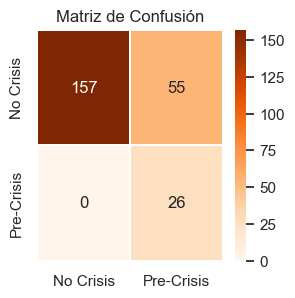


Classification Report
              precision    recall  f1-score   support

   No Crisis       1.00      0.74      0.85       212
  Pre-Crisis       0.32      1.00      0.49        26

    accuracy                           0.77       238
   macro avg       0.66      0.87      0.67       238
weighted avg       0.93      0.77      0.81       238

---------------------------

---------------------------
Algoritmo RF_SMOTE

Mejor Score: 0.4987078639966625
Mejores parámetros: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 7, 'randomforestclassifier__n_estimators': 50}
Average-Precision: 0.499 +/- 0.250


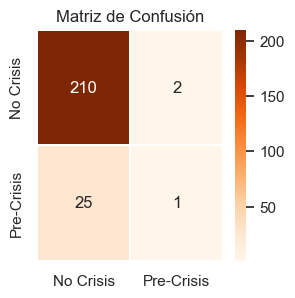


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.89      0.99      0.94       212
  Pre-Crisis       0.33      0.04      0.07        26

    accuracy                           0.89       238
   macro avg       0.61      0.51      0.50       238
weighted avg       0.83      0.89      0.84       238

---------------------------

---------------------------
Algoritmo SVM_SMOTE

Mejor Score: 0.396497865763423
Mejores parámetros: {'svc__C': 0.1, 'svc__gamma': 0.1, 'svc__kernel': 'linear'}
Average-Precision: 0.396 +/- 0.351


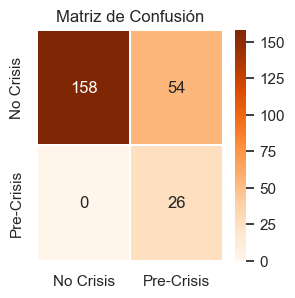


Classification Report
              precision    recall  f1-score   support

   No Crisis       1.00      0.75      0.85       212
  Pre-Crisis       0.33      1.00      0.49        26

    accuracy                           0.77       238
   macro avg       0.66      0.87      0.67       238
weighted avg       0.93      0.77      0.81       238

---------------------------

---------------------------
Algoritmo ADB_SMOTE

Mejor Score: 0.3593648929268311
Mejores parámetros: {'adaboostclassifier__algorithm': 'SAMME.R', 'adaboostclassifier__n_estimators': 15}
Average-Precision: 0.359 +/- 0.277


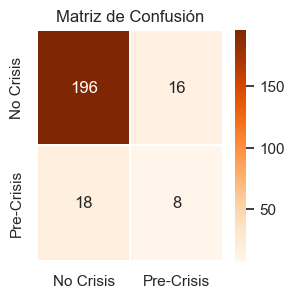


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.92      0.92      0.92       212
  Pre-Crisis       0.33      0.31      0.32        26

    accuracy                           0.86       238
   macro avg       0.62      0.62      0.62       238
weighted avg       0.85      0.86      0.85       238

---------------------------

---------------------------
Algoritmo CART_SMOTE

Mejor Score: 0.34423123387160187
Mejores parámetros: {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 5}
Average-Precision: 0.344 +/- 0.325


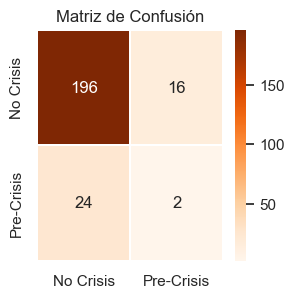


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.89      0.92      0.91       212
  Pre-Crisis       0.11      0.08      0.09        26

    accuracy                           0.83       238
   macro avg       0.50      0.50      0.50       238
weighted avg       0.81      0.83      0.82       238

---------------------------

---------------------------
Algoritmo LOGR_UNDER

Mejor Score: 0.3648700263160635
Mejores parámetros: {'logisticregression__fit_intercept': False, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'sag'}
Average-Precision: 0.365 +/- 0.252


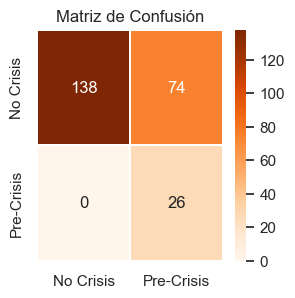


Classification Report
              precision    recall  f1-score   support

   No Crisis       1.00      0.65      0.79       212
  Pre-Crisis       0.26      1.00      0.41        26

    accuracy                           0.69       238
   macro avg       0.63      0.83      0.60       238
weighted avg       0.92      0.69      0.75       238

---------------------------

---------------------------
Algoritmo RF_UNDER

Mejor Score: 0.559843680071941
Mejores parámetros: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 6, 'randomforestclassifier__n_estimators': 50}
Average-Precision: 0.560 +/- 0.233


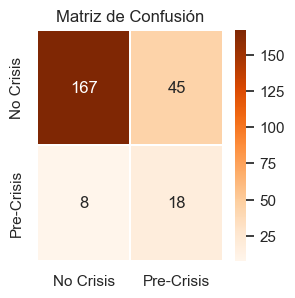


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.95      0.79      0.86       212
  Pre-Crisis       0.29      0.69      0.40        26

    accuracy                           0.78       238
   macro avg       0.62      0.74      0.63       238
weighted avg       0.88      0.78      0.81       238

---------------------------

---------------------------
Algoritmo SVM_UNDER

Mejor Score: 0.4091854352944562
Mejores parámetros: {'svc__C': 0.1, 'svc__gamma': 1, 'svc__kernel': 'poly'}
Average-Precision: 0.409 +/- 0.195


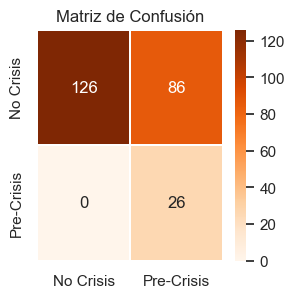


Classification Report
              precision    recall  f1-score   support

   No Crisis       1.00      0.59      0.75       212
  Pre-Crisis       0.23      1.00      0.38        26

    accuracy                           0.64       238
   macro avg       0.62      0.80      0.56       238
weighted avg       0.92      0.64      0.71       238

---------------------------

---------------------------
Algoritmo ADB_UNDER

Mejor Score: 0.40528136115092633
Mejores parámetros: {'adaboostclassifier__algorithm': 'SAMME.R', 'adaboostclassifier__n_estimators': 5}
Average-Precision: 0.405 +/- 0.236


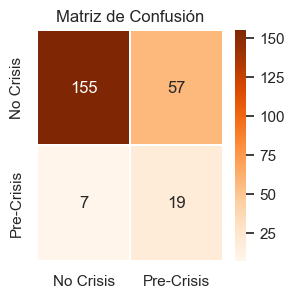


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.96      0.73      0.83       212
  Pre-Crisis       0.25      0.73      0.37        26

    accuracy                           0.73       238
   macro avg       0.60      0.73      0.60       238
weighted avg       0.88      0.73      0.78       238

---------------------------

---------------------------
Algoritmo CART_UNDER

Mejor Score: 0.26278999674160963
Mejores parámetros: {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 2}
Average-Precision: 0.263 +/- 0.178


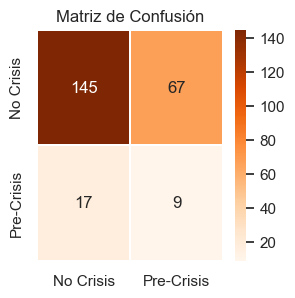


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.90      0.68      0.78       212
  Pre-Crisis       0.12      0.35      0.18        26

    accuracy                           0.65       238
   macro avg       0.51      0.52      0.48       238
weighted avg       0.81      0.65      0.71       238

---------------------------

---------------------------
Algoritmo LOGR_OVER

Mejor Score: 0.38750392673956036
Mejores parámetros: {'logisticregression__fit_intercept': True, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'saga'}
Average-Precision: 0.388 +/- 0.334


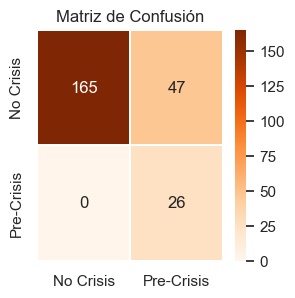


Classification Report
              precision    recall  f1-score   support

   No Crisis       1.00      0.78      0.88       212
  Pre-Crisis       0.36      1.00      0.53        26

    accuracy                           0.80       238
   macro avg       0.68      0.89      0.70       238
weighted avg       0.93      0.80      0.84       238

---------------------------

---------------------------
Algoritmo RF_OVER

Mejor Score: 0.4723725270130498
Mejores parámetros: {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 3, 'randomforestclassifier__n_estimators': 100}
Average-Precision: 0.472 +/- 0.253


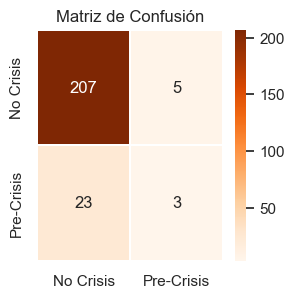


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.90      0.98      0.94       212
  Pre-Crisis       0.38      0.12      0.18        26

    accuracy                           0.88       238
   macro avg       0.64      0.55      0.56       238
weighted avg       0.84      0.88      0.85       238

---------------------------

---------------------------
Algoritmo SVM_OVER

Mejor Score: 0.40764010484320296
Mejores parámetros: {'svc__C': 0.1, 'svc__gamma': 0.1, 'svc__kernel': 'linear'}
Average-Precision: 0.408 +/- 0.359


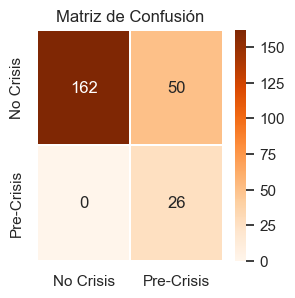


Classification Report
              precision    recall  f1-score   support

   No Crisis       1.00      0.76      0.87       212
  Pre-Crisis       0.34      1.00      0.51        26

    accuracy                           0.79       238
   macro avg       0.67      0.88      0.69       238
weighted avg       0.93      0.79      0.83       238

---------------------------

---------------------------
Algoritmo ADB_OVER

Mejor Score: 0.40865606994503423
Mejores parámetros: {'adaboostclassifier__algorithm': 'SAMME.R', 'adaboostclassifier__n_estimators': 15}
Average-Precision: 0.409 +/- 0.216


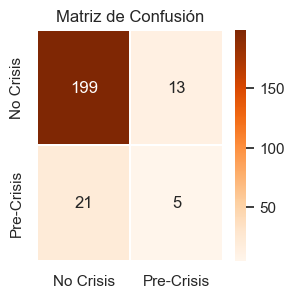


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.90      0.94      0.92       212
  Pre-Crisis       0.28      0.19      0.23        26

    accuracy                           0.86       238
   macro avg       0.59      0.57      0.57       238
weighted avg       0.84      0.86      0.85       238

---------------------------

---------------------------
Algoritmo CART_OVER

Mejor Score: 0.3078649967163899
Mejores parámetros: {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 4}
Average-Precision: 0.308 +/- 0.201


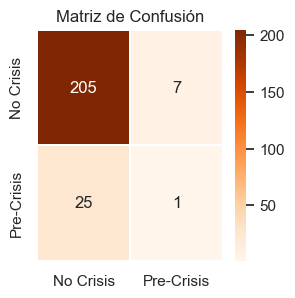


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.89      0.97      0.93       212
  Pre-Crisis       0.12      0.04      0.06        26

    accuracy                           0.87       238
   macro avg       0.51      0.50      0.49       238
weighted avg       0.81      0.87      0.83       238

---------------------------

---------------------------
Algoritmo LOGR_BAL

Mejor Score: 0.41471355185064757
Mejores parámetros: {'logisticregression__fit_intercept': True, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'saga'}
Average-Precision: 0.415 +/- 0.365


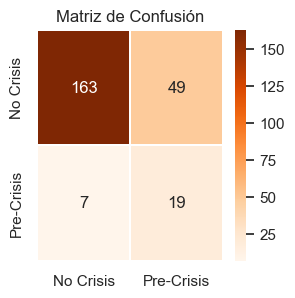


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.96      0.77      0.85       212
  Pre-Crisis       0.28      0.73      0.40        26

    accuracy                           0.76       238
   macro avg       0.62      0.75      0.63       238
weighted avg       0.88      0.76      0.80       238

---------------------------

---------------------------
Algoritmo RF_BAL

Mejor Score: 0.5557115486821405
Mejores parámetros: {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 4, 'randomforestclassifier__n_estimators': 10}
Average-Precision: 0.556 +/- 0.276


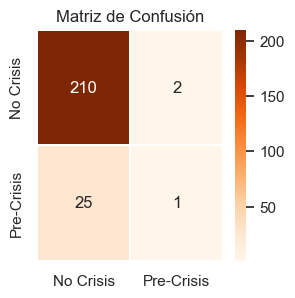


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.89      0.99      0.94       212
  Pre-Crisis       0.33      0.04      0.07        26

    accuracy                           0.89       238
   macro avg       0.61      0.51      0.50       238
weighted avg       0.83      0.89      0.84       238

---------------------------

---------------------------
Algoritmo SVM_BAL

Mejor Score: 0.4092200735890856
Mejores parámetros: {'svc__C': 0.1, 'svc__gamma': 0.1, 'svc__kernel': 'linear'}
Average-Precision: 0.409 +/- 0.358


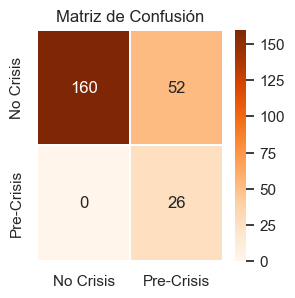


Classification Report
              precision    recall  f1-score   support

   No Crisis       1.00      0.75      0.86       212
  Pre-Crisis       0.33      1.00      0.50        26

    accuracy                           0.78       238
   macro avg       0.67      0.88      0.68       238
weighted avg       0.93      0.78      0.82       238

---------------------------

---------------------------
Algoritmo CART_BAL

Mejor Score: 0.3078649967163899
Mejores parámetros: {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 4}
Average-Precision: 0.308 +/- 0.201


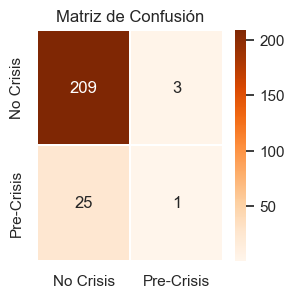


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.89      0.99      0.94       212
  Pre-Crisis       0.25      0.04      0.07        26

    accuracy                           0.88       238
   macro avg       0.57      0.51      0.50       238
weighted avg       0.82      0.88      0.84       238

---------------------------


---------------------------
Algoritmo MLP_SMOTE




2/2 [==============================] - 0s 5ms/step

Matriz de Confusión


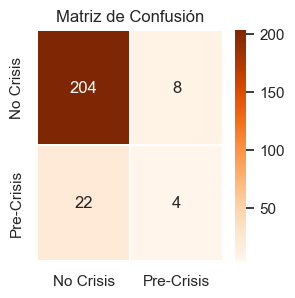


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.90      0.96      0.93       212
  Pre-Crisis       0.33      0.15      0.21        26

    accuracy                           0.87       238
   macro avg       0.62      0.56      0.57       238
weighted avg       0.84      0.87      0.85       238

---------------------------

---------------------------
Algoritmo MLP_UNDER


2/2 [==============================] - 0s 0s/step

Matriz de Confusión


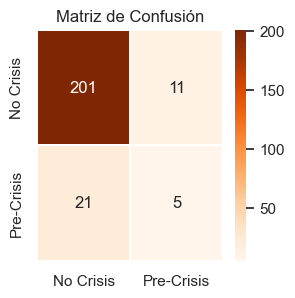


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.91      0.95      0.93       212
  Pre-Crisis       0.31      0.19      0.24        26

    accuracy                           0.87       238
   macro avg       0.61      0.57      0.58       238
weighted avg       0.84      0.87      0.85       238

---------------------------

---------------------------
Algoritmo MLP_OVER


2/2 [==============================] - 0s 5ms/step

Matriz de Confusión


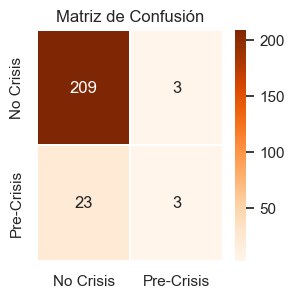


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.90      0.99      0.94       212
  Pre-Crisis       0.50      0.12      0.19        26

    accuracy                           0.89       238
   macro avg       0.70      0.55      0.56       238
weighted avg       0.86      0.89      0.86       238

---------------------------

---------------------------
Algoritmo MLP_BAL


2/2 [==============================] - 0s 0s/step

Matriz de Confusión


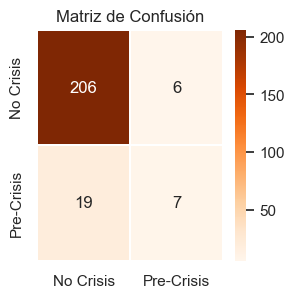


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.92      0.97      0.94       212
  Pre-Crisis       0.54      0.27      0.36        26

    accuracy                           0.89       238
   macro avg       0.73      0.62      0.65       238
weighted avg       0.87      0.89      0.88       238

---------------------------



,LOGR_SMOTE,RF_SMOTE,SVM_SMOTE,ADB_SMOTE,CART_SMOTE,LOGR_UNDER,RF_UNDER,SVM_UNDER,ADB_UNDER,CART_UNDER,LOGR_OVER,RF_OVER,SVM_OVER,ADB_OVER,CART_OVER,LOGR_BAL,RF_BAL,SVM_BAL,CART_BAL,MLP_SMOTE,MLP_UNDER,MLP_OVER,MLP_BAL
Precisión,0.660494,0.613475,0.662500,0.624611,0.501010,0.630000,0.620000,0.616071,0.603395,0.506741,0.678082,0.637500,0.671053,0.591162,0.508152,0.619118,0.613475,0.666667,0.571581,0.617994,0.608953,0.700431,0.727009
Sensibilidad,0.870283,0.514514,0.872642,0.616110,0.500726,0.825472,0.740022,0.797170,0.730951,0.515058,0.889151,0.545900,0.882075,0.565493,0.502721,0.749819,0.514514,0.877358,0.512155,0.558055,0.570210,0.550617,0.620464
F1,0.668465,0.504281,0.672310,0.620094,0.499158,0.600635,0.633772,0.561187,0.600713,0.475936,0.700292,0.556561,0.688057,0.574285,0.493213,0.628829,0.504281,0.680108,0.501943,0.571017,0.582181,0.564471,0.650883
Accuracy,0.768908,0.886555,0.773109,0.857143,0.831933,0.689076,0.777311,0.638655,0.731092,0.647059,0.802521,0.882353,0.789916,0.857143,0.865546,0.764706,0.886555,0.781513,0.882353,0.873950,0.865546,0.890756,0.894958
ROC-AUC,0.870283,0.514514,0.872642,0.616110,0.500726,0.825472,0.740022,0.797170,0.730951,0.515058,0.889151,0.545900,0.882075,0.565493,0.502721,0.749819,0.514514,0.877358,0.512155,0.558055,0.570210,0.550617,0.620464
Precision-Recall,0.320988,0.117863,0.325000,0.178194,0.109387,0.260000,0.231416,0.232143,0.212104,0.112420,0.356164,0.139908,0.342105,0.141654,0.109850,0.233597,0.117863,0.333333,0.114657,0.143719,0.148331,0.154331,0.224802


In [10]:
modelos_entrenados_deleted, tabla_resultados_deleted = entrenar_modelos(X_train_std_deleted, y_train_deleted, X_test_std_deleted, y_test_deleted, columna_anios_deleted, 'delete')

<a id="452"></a>
### 4.5.2.- Entrenamiento para Estrategia de Imputación de Valor Medio para Valores Ausentes

---------------------------
Algoritmo LOGR_SMOTE

Mejor Score: 0.4266398985147206
Mejores parámetros: {'logisticregression__fit_intercept': False, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'sag'}
Average-Precision: 0.427 +/- 0.302


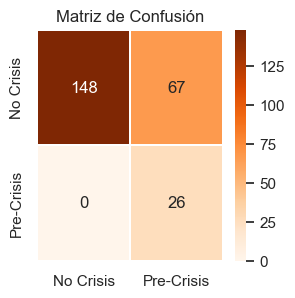


Classification Report
              precision    recall  f1-score   support

   No Crisis       1.00      0.69      0.82       215
  Pre-Crisis       0.28      1.00      0.44        26

    accuracy                           0.72       241
   macro avg       0.64      0.84      0.63       241
weighted avg       0.92      0.72      0.77       241

---------------------------

---------------------------
Algoritmo RF_SMOTE

Mejor Score: 0.307338714727528
Mejores parámetros: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 10}
Average-Precision: 0.307 +/- 0.272


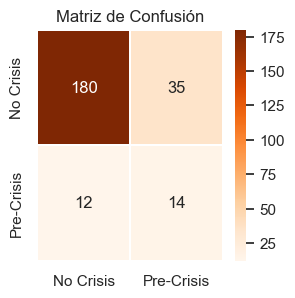


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.94      0.84      0.88       215
  Pre-Crisis       0.29      0.54      0.37        26

    accuracy                           0.80       241
   macro avg       0.61      0.69      0.63       241
weighted avg       0.87      0.80      0.83       241

---------------------------

---------------------------
Algoritmo SVM_SMOTE

Mejor Score: 0.3937381391012803
Mejores parámetros: {'svc__C': 0.1, 'svc__gamma': 0.1, 'svc__kernel': 'poly'}
Average-Precision: 0.394 +/- 0.374


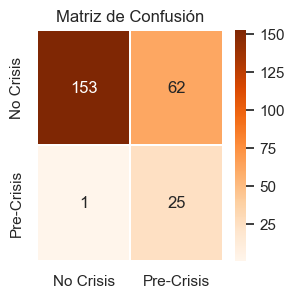


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.99      0.71      0.83       215
  Pre-Crisis       0.29      0.96      0.44        26

    accuracy                           0.74       241
   macro avg       0.64      0.84      0.64       241
weighted avg       0.92      0.74      0.79       241

---------------------------

---------------------------
Algoritmo ADB_SMOTE

Mejor Score: 0.25424471930493936
Mejores parámetros: {'adaboostclassifier__algorithm': 'SAMME.R', 'adaboostclassifier__n_estimators': 15}
Average-Precision: 0.254 +/- 0.288


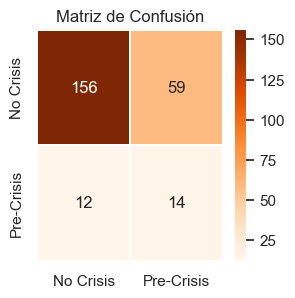


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.93      0.73      0.81       215
  Pre-Crisis       0.19      0.54      0.28        26

    accuracy                           0.71       241
   macro avg       0.56      0.63      0.55       241
weighted avg       0.85      0.71      0.76       241

---------------------------

---------------------------
Algoritmo CART_SMOTE

Mejor Score: 0.19574789858321268
Mejores parámetros: {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 4}
Average-Precision: 0.196 +/- 0.136


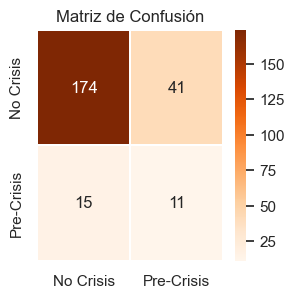


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.92      0.81      0.86       215
  Pre-Crisis       0.21      0.42      0.28        26

    accuracy                           0.77       241
   macro avg       0.57      0.62      0.57       241
weighted avg       0.84      0.77      0.80       241

---------------------------

---------------------------
Algoritmo LOGR_UNDER

Mejor Score: 0.4467739071506235
Mejores parámetros: {'logisticregression__fit_intercept': False, 'logisticregression__penalty': None, 'logisticregression__solver': 'lbfgs'}
Average-Precision: 0.447 +/- 0.293


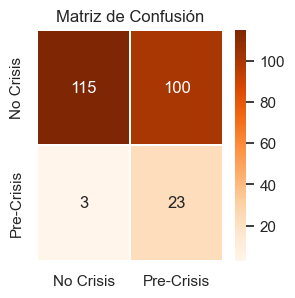


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.97      0.53      0.69       215
  Pre-Crisis       0.19      0.88      0.31        26

    accuracy                           0.57       241
   macro avg       0.58      0.71      0.50       241
weighted avg       0.89      0.57      0.65       241

---------------------------

---------------------------
Algoritmo RF_UNDER

Mejor Score: 0.37426482540626405
Mejores parámetros: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 1, 'randomforestclassifier__n_estimators': 100}
Average-Precision: 0.374 +/- 0.257


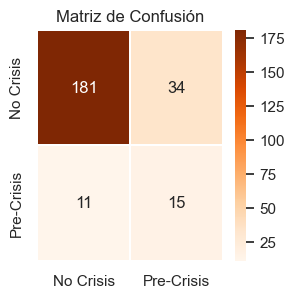


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.94      0.84      0.89       215
  Pre-Crisis       0.31      0.58      0.40        26

    accuracy                           0.81       241
   macro avg       0.62      0.71      0.64       241
weighted avg       0.87      0.81      0.84       241

---------------------------

---------------------------
Algoritmo SVM_UNDER

Mejor Score: 0.38898149511307406
Mejores parámetros: {'svc__C': 1, 'svc__gamma': 1, 'svc__kernel': 'linear'}
Average-Precision: 0.389 +/- 0.378


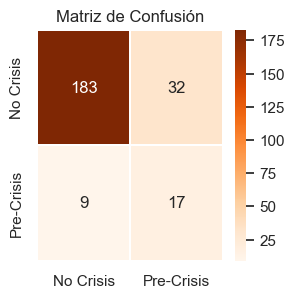


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.95      0.85      0.90       215
  Pre-Crisis       0.35      0.65      0.45        26

    accuracy                           0.83       241
   macro avg       0.65      0.75      0.68       241
weighted avg       0.89      0.83      0.85       241

---------------------------

---------------------------
Algoritmo ADB_UNDER

Mejor Score: 0.2608739892631926
Mejores parámetros: {'adaboostclassifier__algorithm': 'SAMME', 'adaboostclassifier__n_estimators': 15}
Average-Precision: 0.261 +/- 0.306


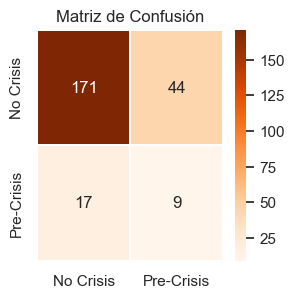


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.91      0.80      0.85       215
  Pre-Crisis       0.17      0.35      0.23        26

    accuracy                           0.75       241
   macro avg       0.54      0.57      0.54       241
weighted avg       0.83      0.75      0.78       241

---------------------------

---------------------------
Algoritmo CART_UNDER

Mejor Score: 0.16294292092883644
Mejores parámetros: {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 1}
Average-Precision: 0.163 +/- 0.154


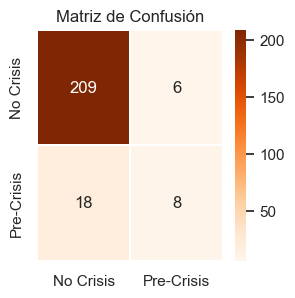


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.92      0.97      0.95       215
  Pre-Crisis       0.57      0.31      0.40        26

    accuracy                           0.90       241
   macro avg       0.75      0.64      0.67       241
weighted avg       0.88      0.90      0.89       241

---------------------------

---------------------------
Algoritmo LOGR_OVER

Mejor Score: 0.4374642803556573
Mejores parámetros: {'logisticregression__fit_intercept': False, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'sag'}
Average-Precision: 0.437 +/- 0.311


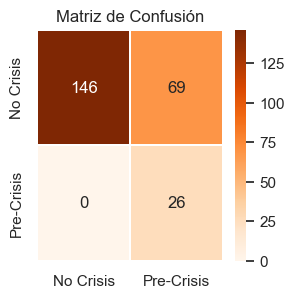


Classification Report
              precision    recall  f1-score   support

   No Crisis       1.00      0.68      0.81       215
  Pre-Crisis       0.27      1.00      0.43        26

    accuracy                           0.71       241
   macro avg       0.64      0.84      0.62       241
weighted avg       0.92      0.71      0.77       241

---------------------------

---------------------------
Algoritmo RF_OVER

Mejor Score: 0.3366861600324263
Mejores parámetros: {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 7, 'randomforestclassifier__n_estimators': 100}
Average-Precision: 0.337 +/- 0.159


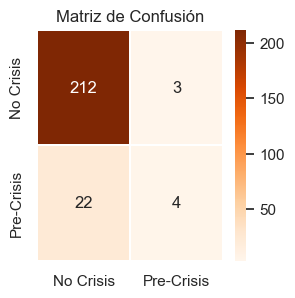


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.91      0.99      0.94       215
  Pre-Crisis       0.57      0.15      0.24        26

    accuracy                           0.90       241
   macro avg       0.74      0.57      0.59       241
weighted avg       0.87      0.90      0.87       241

---------------------------

---------------------------
Algoritmo SVM_OVER

Mejor Score: 0.39132166819458675
Mejores parámetros: {'svc__C': 0.1, 'svc__gamma': 0.1, 'svc__kernel': 'linear'}
Average-Precision: 0.391 +/- 0.367


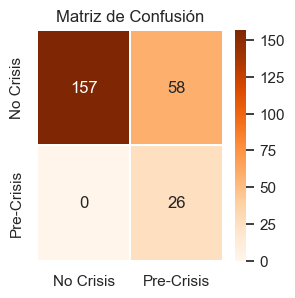


Classification Report
              precision    recall  f1-score   support

   No Crisis       1.00      0.73      0.84       215
  Pre-Crisis       0.31      1.00      0.47        26

    accuracy                           0.76       241
   macro avg       0.65      0.87      0.66       241
weighted avg       0.93      0.76      0.80       241

---------------------------

---------------------------
Algoritmo ADB_OVER

Mejor Score: 0.3698645018645018
Mejores parámetros: {'adaboostclassifier__algorithm': 'SAMME.R', 'adaboostclassifier__n_estimators': 15}
Average-Precision: 0.370 +/- 0.283


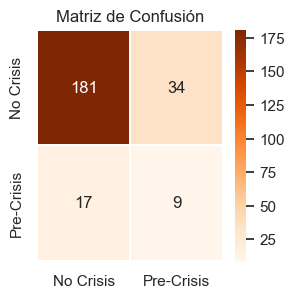


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.91      0.84      0.88       215
  Pre-Crisis       0.21      0.35      0.26        26

    accuracy                           0.79       241
   macro avg       0.56      0.59      0.57       241
weighted avg       0.84      0.79      0.81       241

---------------------------

---------------------------
Algoritmo CART_OVER

Mejor Score: 0.2255478304950136
Mejores parámetros: {'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 4}
Average-Precision: 0.226 +/- 0.215


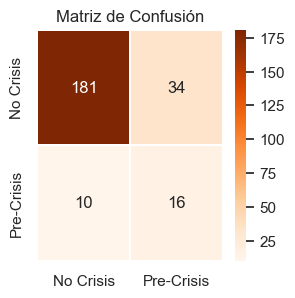


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.95      0.84      0.89       215
  Pre-Crisis       0.32      0.62      0.42        26

    accuracy                           0.82       241
   macro avg       0.63      0.73      0.66       241
weighted avg       0.88      0.82      0.84       241

---------------------------

---------------------------
Algoritmo LOGR_BAL

Mejor Score: 0.43500104918683247
Mejores parámetros: {'logisticregression__fit_intercept': False, 'logisticregression__penalty': None, 'logisticregression__solver': 'lbfgs'}
Average-Precision: 0.435 +/- 0.313


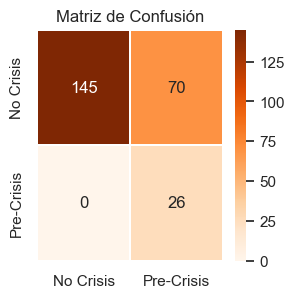


Classification Report
              precision    recall  f1-score   support

   No Crisis       1.00      0.67      0.81       215
  Pre-Crisis       0.27      1.00      0.43        26

    accuracy                           0.71       241
   macro avg       0.64      0.84      0.62       241
weighted avg       0.92      0.71      0.76       241

---------------------------

---------------------------
Algoritmo RF_BAL

Mejor Score: 0.4467801159698241
Mejores parámetros: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 2, 'randomforestclassifier__n_estimators': 100}
Average-Precision: 0.447 +/- 0.269


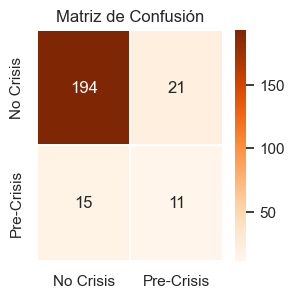


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.93      0.90      0.92       215
  Pre-Crisis       0.34      0.42      0.38        26

    accuracy                           0.85       241
   macro avg       0.64      0.66      0.65       241
weighted avg       0.87      0.85      0.86       241

---------------------------

---------------------------
Algoritmo SVM_BAL

Mejor Score: 0.39495930668918283
Mejores parámetros: {'svc__C': 0.1, 'svc__gamma': 10, 'svc__kernel': 'poly'}
Average-Precision: 0.395 +/- 0.289


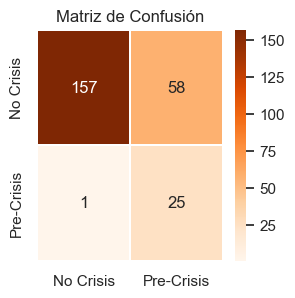


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.99      0.73      0.84       215
  Pre-Crisis       0.30      0.96      0.46        26

    accuracy                           0.76       241
   macro avg       0.65      0.85      0.65       241
weighted avg       0.92      0.76      0.80       241

---------------------------

---------------------------
Algoritmo CART_BAL

Mejor Score: 0.17312395546550474
Mejores parámetros: {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 3}
Average-Precision: 0.173 +/- 0.136


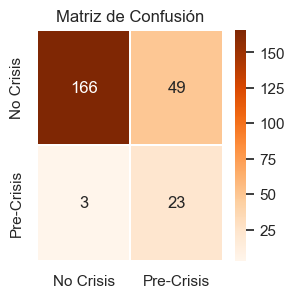


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.98      0.77      0.86       215
  Pre-Crisis       0.32      0.88      0.47        26

    accuracy                           0.78       241
   macro avg       0.65      0.83      0.67       241
weighted avg       0.91      0.78      0.82       241

---------------------------

---------------------------
Algoritmo MLP_SMOTE


2/2 [==============================] - 0s 4ms/step

Matriz de Confusión


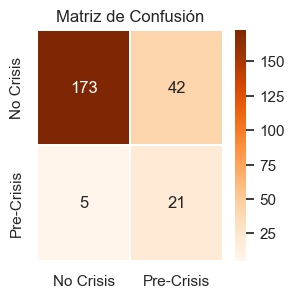


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.97      0.80      0.88       215
  Pre-Crisis       0.33      0.81      0.47        26

    accuracy                           0.80       241
   macro avg       0.65      0.81      0.68       241
weighted avg       0.90      0.80      0.84       241

---------------------------

---------------------------
Algoritmo MLP_UNDER


2/2 [==============================] - 0s 4ms/step

Matriz de Confusión


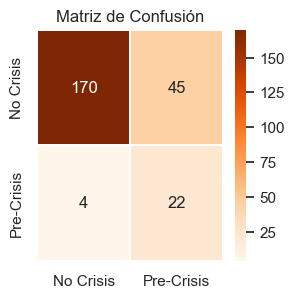


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.98      0.79      0.87       215
  Pre-Crisis       0.33      0.85      0.47        26

    accuracy                           0.80       241
   macro avg       0.65      0.82      0.67       241
weighted avg       0.91      0.80      0.83       241

---------------------------

---------------------------
Algoritmo MLP_OVER


2/2 [==============================] - 0s 0s/step

Matriz de Confusión


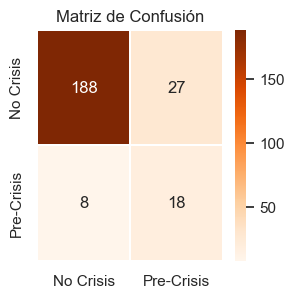


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.96      0.87      0.91       215
  Pre-Crisis       0.40      0.69      0.51        26

    accuracy                           0.85       241
   macro avg       0.68      0.78      0.71       241
weighted avg       0.90      0.85      0.87       241

---------------------------

---------------------------
Algoritmo MLP_BAL


2/2 [==============================] - 0s 4ms/step

Matriz de Confusión


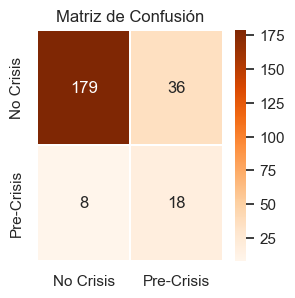


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.96      0.83      0.89       215
  Pre-Crisis       0.33      0.69      0.45        26

    accuracy                           0.82       241
   macro avg       0.65      0.76      0.67       241
weighted avg       0.89      0.82      0.84       241

---------------------------



,LOGR_SMOTE,RF_SMOTE,SVM_SMOTE,ADB_SMOTE,CART_SMOTE,LOGR_UNDER,RF_UNDER,SVM_UNDER,ADB_UNDER,CART_UNDER,LOGR_OVER,RF_OVER,SVM_OVER,ADB_OVER,CART_OVER,LOGR_BAL,RF_BAL,SVM_BAL,CART_BAL,MLP_SMOTE,MLP_UNDER,MLP_OVER,MLP_BAL
Precisión,0.639785,0.611607,0.640431,0.560176,0.566087,0.580784,0.624415,0.650032,0.539693,0.746067,0.636842,0.738706,0.654762,0.561722,0.633822,0.635417,0.635990,0.647438,0.650846,0.652622,0.652685,0.679592,0.645276
Sensibilidad,0.844186,0.687835,0.836583,0.632021,0.616190,0.709750,0.709392,0.752504,0.570751,0.639893,0.839535,0.569946,0.865116,0.594007,0.728623,0.837209,0.662701,0.845886,0.828354,0.806172,0.818426,0.783363,0.762433
F1,0.626201,0.628927,0.635873,0.548725,0.571719,0.499708,0.644717,0.676298,0.538242,0.672851,0.619308,0.593372,0.658407,0.568691,0.656339,0.615893,0.647202,0.650269,0.666986,0.676159,0.673577,0.710942,0.670274
Accuracy,0.721992,0.804979,0.738589,0.705394,0.767635,0.572614,0.813278,0.829876,0.746888,0.900415,0.713693,0.896266,0.759336,0.788382,0.817427,0.709544,0.850622,0.755187,0.784232,0.804979,0.796680,0.854772,0.817427
ROC-AUC,0.844186,0.687835,0.836583,0.632021,0.616190,0.709750,0.709392,0.752504,0.570751,0.639893,0.839535,0.569946,0.865116,0.594007,0.728623,0.837209,0.662701,0.845886,0.828354,0.806172,0.818426,0.783363,0.762433
Precision-Recall,0.279570,0.203639,0.280454,0.153059,0.151738,0.177864,0.222252,0.264189,0.129320,0.250513,0.273684,0.179198,0.309524,0.142990,0.238417,0.270833,0.207673,0.293769,0.295034,0.289978,0.294439,0.310118,0.263964


In [11]:
modelos_entrenados_media, tabla_resultados_media = entrenar_modelos(X_train_std_media, y_train_media, X_test_std_media, y_test_media, columna_anios, 'media')

<a id="453"></a>
### 4.5.3.- Entrenamiento para Estrategia de Imputación mediante KNN para Valores Ausentes

---------------------------
Algoritmo LOGR_SMOTE

Mejor Score: 0.4266993162211971
Mejores parámetros: {'logisticregression__fit_intercept': False, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'sag'}
Average-Precision: 0.427 +/- 0.302


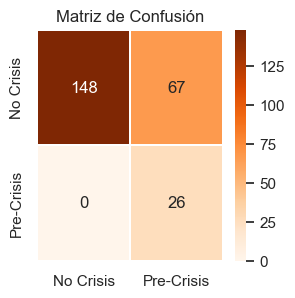


Classification Report
              precision    recall  f1-score   support

   No Crisis       1.00      0.69      0.82       215
  Pre-Crisis       0.28      1.00      0.44        26

    accuracy                           0.72       241
   macro avg       0.64      0.84      0.63       241
weighted avg       0.92      0.72      0.77       241

---------------------------

---------------------------
Algoritmo RF_SMOTE

Mejor Score: 0.29540182831693873
Mejores parámetros: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 6, 'randomforestclassifier__n_estimators': 100}
Average-Precision: 0.295 +/- 0.218


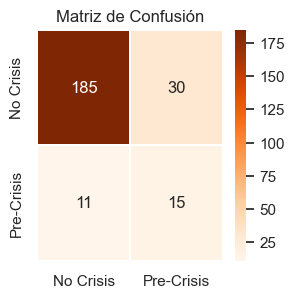


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.94      0.86      0.90       215
  Pre-Crisis       0.33      0.58      0.42        26

    accuracy                           0.83       241
   macro avg       0.64      0.72      0.66       241
weighted avg       0.88      0.83      0.85       241

---------------------------

---------------------------
Algoritmo SVM_SMOTE

Mejor Score: 0.3937486416481479
Mejores parámetros: {'svc__C': 0.1, 'svc__gamma': 0.1, 'svc__kernel': 'poly'}
Average-Precision: 0.394 +/- 0.374


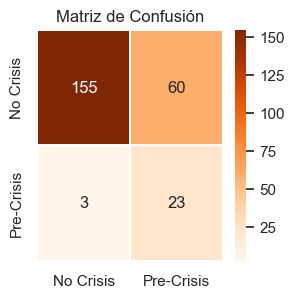


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.98      0.72      0.83       215
  Pre-Crisis       0.28      0.88      0.42        26

    accuracy                           0.74       241
   macro avg       0.63      0.80      0.63       241
weighted avg       0.91      0.74      0.79       241

---------------------------

---------------------------
Algoritmo ADB_SMOTE

Mejor Score: 0.24476350222655813
Mejores parámetros: {'adaboostclassifier__algorithm': 'SAMME.R', 'adaboostclassifier__n_estimators': 15}
Average-Precision: 0.245 +/- 0.292


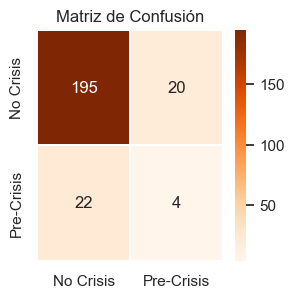


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.90      0.91      0.90       215
  Pre-Crisis       0.17      0.15      0.16        26

    accuracy                           0.83       241
   macro avg       0.53      0.53      0.53       241
weighted avg       0.82      0.83      0.82       241

---------------------------

---------------------------
Algoritmo CART_SMOTE

Mejor Score: 0.2033640433640434
Mejores parámetros: {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 5}
Average-Precision: 0.203 +/- 0.103


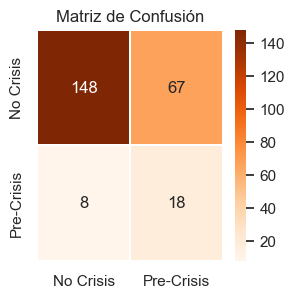


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.95      0.69      0.80       215
  Pre-Crisis       0.21      0.69      0.32        26

    accuracy                           0.69       241
   macro avg       0.58      0.69      0.56       241
weighted avg       0.87      0.69      0.75       241

---------------------------

---------------------------
Algoritmo LOGR_UNDER

Mejor Score: 0.43959136746808375
Mejores parámetros: {'logisticregression__fit_intercept': False, 'logisticregression__penalty': None, 'logisticregression__solver': 'lbfgs'}
Average-Precision: 0.440 +/- 0.287


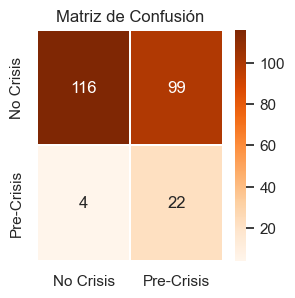


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.97      0.54      0.69       215
  Pre-Crisis       0.18      0.85      0.30        26

    accuracy                           0.57       241
   macro avg       0.57      0.69      0.50       241
weighted avg       0.88      0.57      0.65       241

---------------------------

---------------------------
Algoritmo RF_UNDER

Mejor Score: 0.3817053015967402
Mejores parámetros: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 1, 'randomforestclassifier__n_estimators': 100}
Average-Precision: 0.382 +/- 0.255


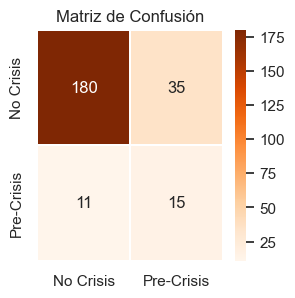


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.94      0.84      0.89       215
  Pre-Crisis       0.30      0.58      0.39        26

    accuracy                           0.81       241
   macro avg       0.62      0.71      0.64       241
weighted avg       0.87      0.81      0.83       241

---------------------------

---------------------------
Algoritmo SVM_UNDER

Mejor Score: 0.3976759326524573
Mejores parámetros: {'svc__C': 10, 'svc__gamma': 1, 'svc__kernel': 'linear'}
Average-Precision: 0.398 +/- 0.353


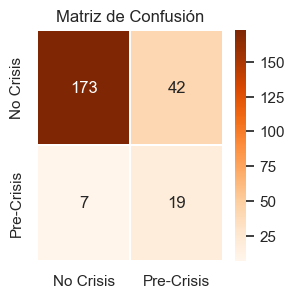


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.96      0.80      0.88       215
  Pre-Crisis       0.31      0.73      0.44        26

    accuracy                           0.80       241
   macro avg       0.64      0.77      0.66       241
weighted avg       0.89      0.80      0.83       241

---------------------------

---------------------------
Algoritmo ADB_UNDER

Mejor Score: 0.3106704005813431
Mejores parámetros: {'adaboostclassifier__algorithm': 'SAMME', 'adaboostclassifier__n_estimators': 15}
Average-Precision: 0.311 +/- 0.309


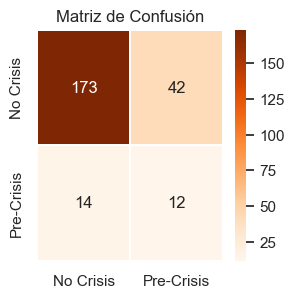


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.93      0.80      0.86       215
  Pre-Crisis       0.22      0.46      0.30        26

    accuracy                           0.77       241
   macro avg       0.57      0.63      0.58       241
weighted avg       0.85      0.77      0.80       241

---------------------------

---------------------------
Algoritmo CART_UNDER

Mejor Score: 0.16294292092883644
Mejores parámetros: {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 1}
Average-Precision: 0.163 +/- 0.154


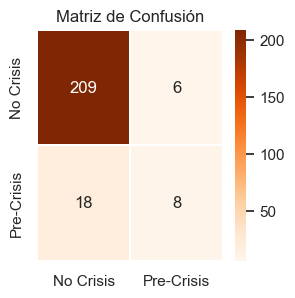


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.92      0.97      0.95       215
  Pre-Crisis       0.57      0.31      0.40        26

    accuracy                           0.90       241
   macro avg       0.75      0.64      0.67       241
weighted avg       0.88      0.90      0.89       241

---------------------------

---------------------------
Algoritmo LOGR_OVER

Mejor Score: 0.4376811739975127
Mejores parámetros: {'logisticregression__fit_intercept': False, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'saga'}
Average-Precision: 0.438 +/- 0.311


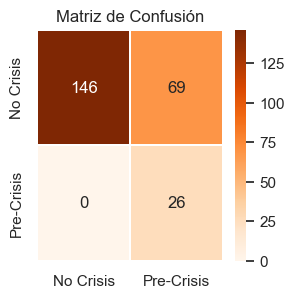


Classification Report
              precision    recall  f1-score   support

   No Crisis       1.00      0.68      0.81       215
  Pre-Crisis       0.27      1.00      0.43        26

    accuracy                           0.71       241
   macro avg       0.64      0.84      0.62       241
weighted avg       0.92      0.71      0.77       241

---------------------------

---------------------------
Algoritmo RF_OVER

Mejor Score: 0.3565634638551726
Mejores parámetros: {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 3, 'randomforestclassifier__n_estimators': 50}
Average-Precision: 0.357 +/- 0.208


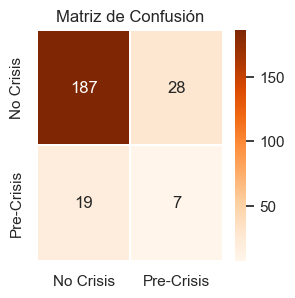


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.91      0.87      0.89       215
  Pre-Crisis       0.20      0.27      0.23        26

    accuracy                           0.80       241
   macro avg       0.55      0.57      0.56       241
weighted avg       0.83      0.80      0.82       241

---------------------------

---------------------------
Algoritmo SVM_OVER

Mejor Score: 0.39183480911198304
Mejores parámetros: {'svc__C': 0.1, 'svc__gamma': 10, 'svc__kernel': 'linear'}
Average-Precision: 0.392 +/- 0.367


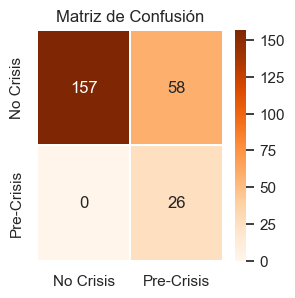


Classification Report
              precision    recall  f1-score   support

   No Crisis       1.00      0.73      0.84       215
  Pre-Crisis       0.31      1.00      0.47        26

    accuracy                           0.76       241
   macro avg       0.65      0.87      0.66       241
weighted avg       0.93      0.76      0.80       241

---------------------------

---------------------------
Algoritmo ADB_OVER

Mejor Score: 0.2894117013115729
Mejores parámetros: {'adaboostclassifier__algorithm': 'SAMME.R', 'adaboostclassifier__n_estimators': 15}
Average-Precision: 0.289 +/- 0.278


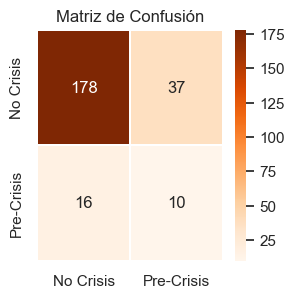


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.92      0.83      0.87       215
  Pre-Crisis       0.21      0.38      0.27        26

    accuracy                           0.78       241
   macro avg       0.57      0.61      0.57       241
weighted avg       0.84      0.78      0.81       241

---------------------------

---------------------------
Algoritmo CART_OVER

Mejor Score: 0.2193246508410877
Mejores parámetros: {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 4}
Average-Precision: 0.219 +/- 0.219


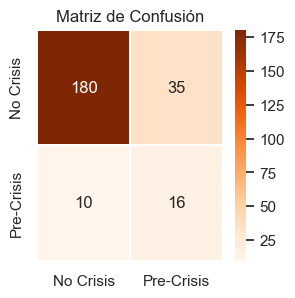


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.95      0.84      0.89       215
  Pre-Crisis       0.31      0.62      0.42        26

    accuracy                           0.81       241
   macro avg       0.63      0.73      0.65       241
weighted avg       0.88      0.81      0.84       241

---------------------------

---------------------------
Algoritmo LOGR_BAL

Mejor Score: 0.4627958185898199
Mejores parámetros: {'logisticregression__fit_intercept': False, 'logisticregression__penalty': None, 'logisticregression__solver': 'saga'}
Average-Precision: 0.463 +/- 0.301


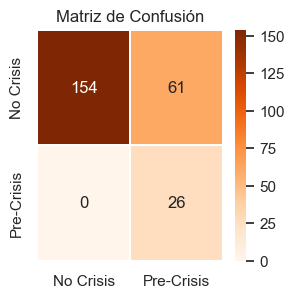


Classification Report
              precision    recall  f1-score   support

   No Crisis       1.00      0.72      0.83       215
  Pre-Crisis       0.30      1.00      0.46        26

    accuracy                           0.75       241
   macro avg       0.65      0.86      0.65       241
weighted avg       0.92      0.75      0.79       241

---------------------------

---------------------------
Algoritmo RF_BAL

Mejor Score: 0.4487980972920592
Mejores parámetros: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 2, 'randomforestclassifier__n_estimators': 100}
Average-Precision: 0.449 +/- 0.268


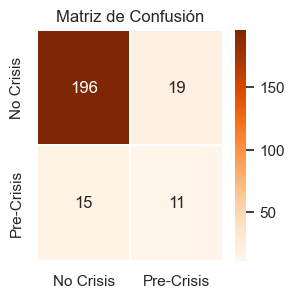


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.93      0.91      0.92       215
  Pre-Crisis       0.37      0.42      0.39        26

    accuracy                           0.86       241
   macro avg       0.65      0.67      0.66       241
weighted avg       0.87      0.86      0.86       241

---------------------------

---------------------------
Algoritmo SVM_BAL

Mejor Score: 0.39110955102890826
Mejores parámetros: {'svc__C': 1, 'svc__gamma': 0.1, 'svc__kernel': 'linear'}
Average-Precision: 0.391 +/- 0.366


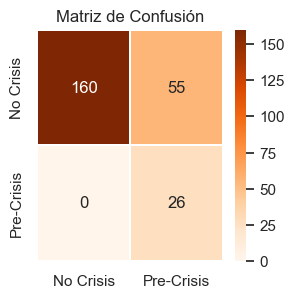


Classification Report
              precision    recall  f1-score   support

   No Crisis       1.00      0.74      0.85       215
  Pre-Crisis       0.32      1.00      0.49        26

    accuracy                           0.77       241
   macro avg       0.66      0.87      0.67       241
weighted avg       0.93      0.77      0.81       241

---------------------------

---------------------------
Algoritmo CART_BAL

Mejor Score: 0.17407420970766732
Mejores parámetros: {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 3}
Average-Precision: 0.174 +/- 0.126


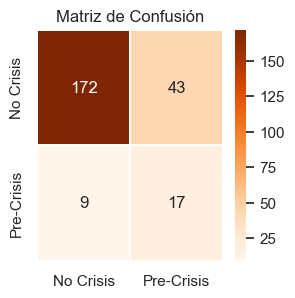


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.95      0.80      0.87       215
  Pre-Crisis       0.28      0.65      0.40        26

    accuracy                           0.78       241
   macro avg       0.62      0.73      0.63       241
weighted avg       0.88      0.78      0.82       241

---------------------------

---------------------------
Algoritmo MLP_SMOTE


2/2 [==============================] - 0s 5ms/step

Matriz de Confusión


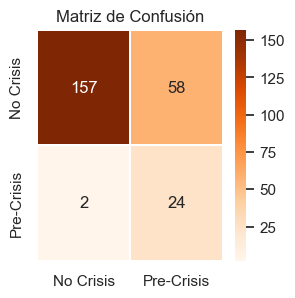


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.99      0.73      0.84       215
  Pre-Crisis       0.29      0.92      0.44        26

    accuracy                           0.75       241
   macro avg       0.64      0.83      0.64       241
weighted avg       0.91      0.75      0.80       241

---------------------------

---------------------------
Algoritmo MLP_UNDER


2/2 [==============================] - 0s 5ms/step

Matriz de Confusión


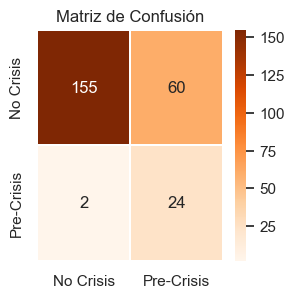


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.99      0.72      0.83       215
  Pre-Crisis       0.29      0.92      0.44        26

    accuracy                           0.74       241
   macro avg       0.64      0.82      0.63       241
weighted avg       0.91      0.74      0.79       241

---------------------------

---------------------------
Algoritmo MLP_OVER


2/2 [==============================] - 0s 1ms/step

Matriz de Confusión


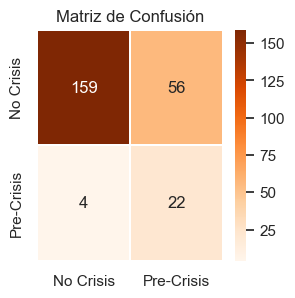


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.98      0.74      0.84       215
  Pre-Crisis       0.28      0.85      0.42        26

    accuracy                           0.75       241
   macro avg       0.63      0.79      0.63       241
weighted avg       0.90      0.75      0.80       241

---------------------------

---------------------------
Algoritmo MLP_BAL


2/2 [==============================] - 0s 0s/step

Matriz de Confusión


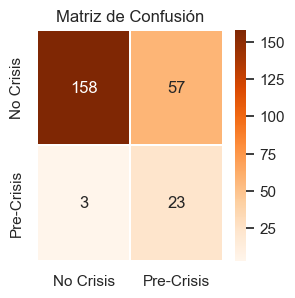


Classification Report
              precision    recall  f1-score   support

   No Crisis       0.98      0.73      0.84       215
  Pre-Crisis       0.29      0.88      0.43        26

    accuracy                           0.75       241
   macro avg       0.63      0.81      0.64       241
weighted avg       0.91      0.75      0.80       241

---------------------------



,LOGR_SMOTE,RF_SMOTE,SVM_SMOTE,ADB_SMOTE,CART_SMOTE,LOGR_UNDER,RF_UNDER,SVM_UNDER,ADB_UNDER,CART_UNDER,LOGR_OVER,RF_OVER,SVM_OVER,ADB_OVER,CART_OVER,LOGR_BAL,RF_BAL,SVM_BAL,CART_BAL,MLP_SMOTE,MLP_UNDER,MLP_OVER,MLP_BAL
Precisión,0.639785,0.638605,0.629061,0.532642,0.580241,0.574242,0.621204,0.636293,0.573678,0.746067,0.636842,0.553883,0.654762,0.565146,0.630547,0.649425,0.647788,0.660494,0.616805,0.640052,0.636488,0.628756,0.634433
Sensibilidad,0.844186,0.718694,0.802773,0.530411,0.690340,0.692844,0.707066,0.767710,0.633095,0.639893,0.839535,0.569499,0.865116,0.606261,0.726297,0.858140,0.667352,0.872093,0.726923,0.826655,0.822004,0.792844,0.809750
F1,0.626201,0.661389,0.626559,0.531389,0.561084,0.495929,0.640718,0.656365,0.580348,0.672851,0.619308,0.558935,0.658407,0.572194,0.652237,0.647433,0.656522,0.669657,0.632018,0.642008,0.634848,0.632173,0.637194
Accuracy,0.721992,0.829876,0.738589,0.825726,0.688797,0.572614,0.809129,0.796680,0.767635,0.900415,0.713693,0.804979,0.759336,0.780083,0.813278,0.746888,0.858921,0.771784,0.784232,0.751037,0.742739,0.751037,0.751037
ROC-AUC,0.844186,0.718694,0.802773,0.530411,0.690340,0.692844,0.707066,0.767710,0.633095,0.639893,0.839535,0.569499,0.865116,0.606261,0.726297,0.858140,0.667352,0.872093,0.726923,0.826655,0.822004,0.792844,0.809750
Precision-Recall,0.279570,0.237951,0.257583,0.116927,0.179801,0.170444,0.218720,0.256662,0.160655,0.250513,0.273684,0.132684,0.309524,0.148223,0.234556,0.298851,0.217369,0.320988,0.222601,0.278468,0.272035,0.255256,0.266775


In [12]:
modelos_entrenados_knn, tabla_resultados_knn = entrenar_modelos(X_train_std_knn, y_train_knn, X_test_std_knn, y_test_knn, columna_anios, 'knn')

<a id="46"></a>
## 4.6.- Obtención de mejores modelos

De entre todas las combinaciones se obtendrá el mejor modelo para cada una de las distintas estrategias de imputación de valores ausentes en base al valor de la métrica seleccionada ("average_precision_score"), para posteriormente seleccionar el mejor modelo global:

In [13]:
# Obtenemos los mejores modelos de cada estrategia
tabla_mejores_modelos = pd.concat([tabla_resultados_deleted.iloc[:,tabla_resultados_deleted.iloc[5].argmax()],
                             tabla_resultados_media.iloc[:,tabla_resultados_media.iloc[5].argmax()],
                             tabla_resultados_knn.iloc[:,tabla_resultados_knn.iloc[5].argmax()]],axis=1)

mejores_modelos_entrenados = [modelos_entrenados_deleted[tabla_resultados_deleted.iloc[5].argmax()],
                              modelos_entrenados_media[tabla_resultados_media.iloc[5].argmax()],
                              modelos_entrenados_knn[tabla_resultados_knn.iloc[5].argmax()]]
display(tabla_mejores_modelos)

# Obtenemos el mejor modelo global
tabla_mejor_modelo = tabla_mejores_modelos.iloc[:,tabla_mejores_modelos.iloc[5].argmax()]
display(tabla_mejor_modelo)
mejor_modelo_entrenado = mejores_modelos_entrenados[tabla_mejores_modelos.iloc[5].argmax()]


,LOGR_OVER,MLP_OVER,SVM_BAL
Precisión,0.678082,0.679592,0.660494
Sensibilidad,0.889151,0.783363,0.872093
F1,0.700292,0.710942,0.669657
Accuracy,0.802521,0.854772,0.771784
ROC-AUC,0.889151,0.783363,0.872093
Precision-Recall,0.356164,0.310118,0.320988


Precisión           0.678082
Sensibilidad        0.889151
F1                  0.700292
Accuracy            0.802521
ROC-AUC             0.889151
Precision-Recall    0.356164
Name: LOGR_OVER, dtype: float64

<a id="47"></a>
## 4.7.- Interpretabilidad de modelo Regresión Logística

Dado que el mejor modelo ha sido uno basado en Regresión Logística, podemos evaluar la importancia de cada atributo en base al coeficiente asociado.
Se obtendrán dichos coeficientes para evaluar su coherencia con el marco teórico expuesto al inicio de la memoria. 

In [63]:
# Obtenemos los coeficientes y término independiente del modelo de regresión logística
print(atributos_discriminativos_deleted)
print(f'\nCoeficientes: {mejor_modelo_entrenado["logisticregression"].coef_} - Término independiente: {mejor_modelo_entrenado["logisticregression"].intercept_}')

['cpi_dif_por2', 'ca_pib_dif_abs2', 'tloans_pib_dif_abs2', 'tdbtserv_pib_dif_abs2', 'global_loan2', 'global_drate', 'drate']

Coeficientes: [[ 1.54654589 -0.85976339  0.23903861 -0.02990926  0.34087507 -0.15449538
  -0.43345936]] - Término independiente: [-0.68795498]


<a id="48"></a>
## 4.8.- Obtención de fronteras de decisición para modelos CART

Obtendremos los árboles de decisión correspondientes a distintos modelos basados en CART para su comparativa en la memoria.

In [14]:
from sklearn.tree import export_text

    # Recuperamos las etiquetas de los atributos
with open('../preprocesadores/atributos_discriminativos_deleted.pkl', 'rb') as f:
    atributos_discriminativos_deleted = pickle.load(f)

with open('../preprocesadores/atributos_discriminativos_knn.pkl', 'rb') as f:
    atributos_discriminativos_knn = pickle.load(f)

    # Ejemplo de Árbol de Decisión CART con malos resultados
print('Ejemplo de Árbol de Decisión CART con malos resultados\n')
print(export_text(modelos_entrenados_deleted[4]['decisiontreeclassifier'],
                  feature_names=atributos_discriminativos_deleted,
                  class_names=['No Crisis', 'Pre-Crisis'],
                  show_weights=True))

    # Ejemplo de Árbol de Decisión CART con buenos resultados
print('\n\nEjemplo de Árbol de Decisión CART con buenos resultados\n')
print(export_text(modelos_entrenados_knn[4]['decisiontreeclassifier'],
                  feature_names=atributos_discriminativos_knn,
                  class_names=['No Crisis', 'Pre-Crisis'],
                  show_weights=True))

Ejemplo de Árbol de Decisión CART con malos resultados

|--- cpi_dif_por2 <= -0.09
|   |--- drate <= -2.42
|   |   |--- global_drate <= -2.17
|   |   |   |--- weights: [0.00, 30.00] class: Pre-Crisis
|   |   |--- global_drate >  -2.17
|   |   |   |--- weights: [1.00, 0.00] class: No Crisis
|   |--- drate >  -2.42
|   |   |--- tdbtserv_pib_dif_abs2 <= -1.34
|   |   |   |--- ca_pib_dif_abs2 <= -0.32
|   |   |   |   |--- drate <= -0.23
|   |   |   |   |   |--- weights: [6.00, 0.00] class: No Crisis
|   |   |   |   |--- drate >  -0.23
|   |   |   |   |   |--- weights: [2.00, 56.00] class: Pre-Crisis
|   |   |   |--- ca_pib_dif_abs2 >  -0.32
|   |   |   |   |--- weights: [29.00, 0.00] class: No Crisis
|   |   |--- tdbtserv_pib_dif_abs2 >  -1.34
|   |   |   |--- tloans_pib_dif_abs2 <= -1.01
|   |   |   |   |--- ca_pib_dif_abs2 <= -0.18
|   |   |   |   |   |--- weights: [6.00, 10.00] class: Pre-Crisis
|   |   |   |   |--- ca_pib_dif_abs2 >  -0.18
|   |   |   |   |   |--- weights: [22.00, 0.00

<a id="49"></a>
## 4.9.- Curvas ROC y Precisión-Sensibilidad para mejor modelo

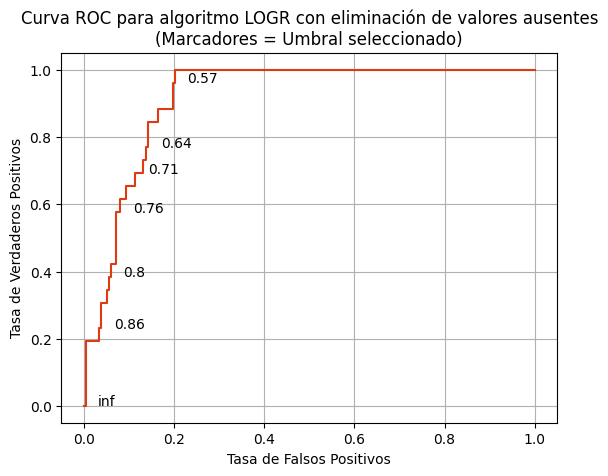

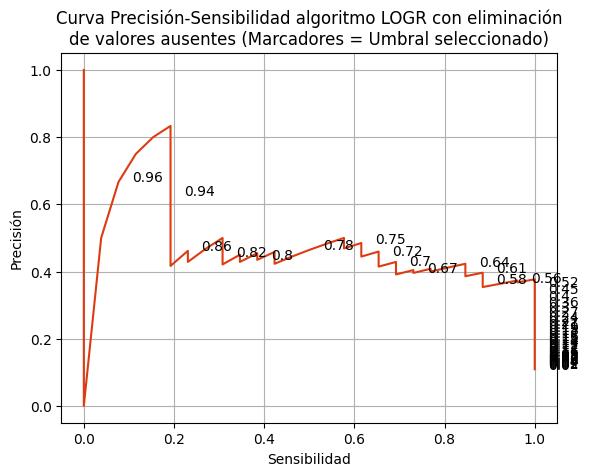

In [61]:
import matplotlib as mpl
mpl.style.use('default')

# Guardo para usar en la app
if not os.path.exists('../app/graficas'):
    os.mkdir('../app/graficas')

# Mostramos la curva ROC para el mejor modelo
fig, ax = plt.subplots()
y_proba_aux = mejor_modelo_entrenado["logisticregression"].predict_proba(X_test_std_deleted)
fpr_aux, tpr_aux, th_aux = metrics.roc_curve(y_test_deleted, y_proba_aux[:,1])
plt.plot(fpr_aux, tpr_aux, color='#dd3c12')
# Incluímos los thresholds como anotaciones
for xx, yy, txt in zip(fpr_aux[::5], tpr_aux[::5], th_aux[::5]):
    plt.annotate(np.round(txt,2), (xx+0.03, yy))
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC para algoritmo LOGR con eliminación de valores ausentes\n(Marcadores = Umbral seleccionado)')
plt.grid()
plt.savefig('../app/graficas/ROC_curve.png')
plt.show()

# Mostramos la curva precision-recall para el mejor modelo
pr_aux, rec_aux, th_aux = metrics.precision_recall_curve(y_test_deleted, y_proba_aux[:,1])
plt.plot(rec_aux, pr_aux, color='#dd3c12')
# Incluímos los thresholds como anotaciones
for xx, yy, txt in zip(rec_aux[::5], pr_aux[::5], th_aux[::5]):
    plt.annotate(np.round(txt,2), (xx+0.03, yy))
plt.xlabel('Sensibilidad')
plt.ylabel('Precisión')
plt.title('Curva Precisión-Sensibilidad algoritmo LOGR con eliminación\nde valores ausentes (Marcadores = Umbral seleccionado)')
plt.grid()
plt.savefig('../app/graficas/PR_curve.png')
plt.show()

<a id="410"></a>
## 4.10.- Almacenamiento de modelos y tablas de resultados

Se guardarán para las distintas estrategias de imputación de valores ausentes empleadas, todos los modelos entrenados y sus tablas de métricas para futuro uso.

En concreto el mejor modelo entrenado se usará como parte de la interfaz gráfica para el cálculo de predicciones.

In [15]:
# Guardamos los diferentes modelos entrenados y las tablas de resultados

if not os.path.exists('../modelos_entrenados'):
    os.mkdir('../modelos_entrenados')

    # Estrategia eliminación de valores ausentes
with open('../modelos_entrenados/modelos_entrenados_deleted.pkl', 'wb') as f:
    pickle.dump(modelos_entrenados_deleted, f)

with open('../modelos_entrenados/tabla_resultados_deleted.pkl', 'wb') as f:
    pickle.dump(tabla_resultados_deleted, f)

# Estrategia imputación por valor medio
with open('../modelos_entrenados/modelos_entrenados_media.pkl', 'wb') as f:
    pickle.dump(modelos_entrenados_media, f)

with open('../modelos_entrenados/tabla_resultados_media.pkl', 'wb') as f:
    pickle.dump(tabla_resultados_media, f)

# Estrategia imputación por algoritmo KNN
with open('../modelos_entrenados/modelos_entrenados_knn.pkl', 'wb') as f:
    pickle.dump(modelos_entrenados_knn, f)

with open('../modelos_entrenados/tabla_resultados_knn.pkl', 'wb') as f:
    pickle.dump(tabla_resultados_knn, f)

# Mejores modelos
with open('../modelos_entrenados/mejores_modelos_entrenados.pkl', 'wb') as f:
    pickle.dump(mejores_modelos_entrenados, f)

with open('../modelos_entrenados/tabla_mejores_modelos.pkl', 'wb') as f:
    pickle.dump(tabla_mejores_modelos, f)

# Mejor modelo final
with open('../modelos_entrenados/mejor_modelo_entrenado.pkl', 'wb') as f:
    pickle.dump(mejor_modelo_entrenado, f)

with open('../modelos_entrenados/tabla_mejor_modelo.pkl', 'wb') as f:
    pickle.dump(tabla_mejor_modelo, f)

